<a href="https://colab.research.google.com/github/azfarkhoja305/GANs/blob/main/notebooks/Evaluate_TransGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [18]:
# Check GPU
!nvidia-smi

Tue Apr 20 10:09:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.92       Driver Version: 461.92       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106... WDDM  | 00000000:07:00.0  On |                  N/A |
|  0%   42C    P2    25W / 120W |   5950MiB /  6144MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
import os
import sys
import pdb
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import animation, rc
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# from torchsummary import summary
from types import SimpleNamespace
import json
from metrics.torch_is_fid_score import is_fid_from_generator

In [20]:
from models.transformer_generator import TGenerator
from models.ViT_discriminator import Discriminator
from utils.utils import check_gpu, display_images, set_seed
from utils.checkpoint import Checkpoint
from utils.loss import wgangp_eps_loss
from utils.datasets import ImageDataset
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
gdrive = Path('C:\\GANs\\')

In [22]:
# seed notebook
set_seed(seed=123)
device = check_gpu()
print(f'Using device: {device}')

Using device: cuda


In [23]:
!set PYTHONPATH=%PYTHONPATH%;C:/GitHub/GANs && python ./scripts/create_fid_stats.py -d cifar_10 -t False

Namespace(batch_size=256, dataset='cifar_10', save='fid_stats', train='False')
Files already downloaded and verified
fid_stats\cifar_10_valid_fid_stats.npz exists. Exiting !!!


# Inference

In [24]:
gen_batch_sz = 64
dis_batch_sz = 32
latent_dims = 1024
lr, beta1, beta2 = 1e-4, 0, 0.999

In [25]:
# Add Horizontal Flip by default
tfms = [transforms.RandomHorizontalFlip()]
dataset =  ImageDataset('cifar_10', batch_sz=dis_batch_sz, tfms=tfms, 
                        num_workers=2, drop_last=True)
# display_images(dataset.train_loader)

Files already downloaded and verified


In [26]:
Gen = TGenerator(latent_dims=latent_dims).to(device)
fixed_z = torch.randn(gen_batch_sz, latent_dims, device=device)
# summary(Gen,(latent_dims,))

In [27]:
args = SimpleNamespace(**{"d_depth": 7, "df_dim": 384, "img_size": 32, "patch_size": 8})
Dis = Discriminator(args).to(device)
# summary(Dis,(3,32,32,))

In [28]:
optG = optim.AdamW(Gen.parameters(), lr=lr, betas=(beta1, beta2))
optD = optim.AdamW(Dis.parameters(), lr=lr, betas=(beta1, beta2))

In [29]:
with open('results.json') as fp:
  results = json.load(fp)

In [34]:
stat_path = Path('fid_stats/cifar_10_valid_fid_stats.npz')
experiments = ['no_aug', 'flip_lr', 'full_aug', 'co_training', "attn_init"]

for exp in experiments:
  ckp_folder = gdrive/exp
  for filename in os.listdir(ckp_folder):
      if exp not in results:
          results[exp] = {'epochs':[],'iss':[],'fids':[]}
      epoch = int(filename[:-4].split('_')[-1])
      if epoch not in results[exp]['epochs']:
      
          Gen, Dis, optG, optD, start_epoch, old_logs = \
              Checkpoint.load_checkpoint(ckp_folder/filename, Gen, Dis, optG, optD)
          assert start_epoch > 0
          
          inception_score, fid = is_fid_from_generator(generator=Gen,
                                                  latent_dims=latent_dims,
                                                  num_imgs=10000,
                                                  batch_sz=64,
                                                  fid_stat_path = stat_path)
          print(fid)
          results[exp]['iss'].append(inception_score)
          results[exp]['fids'].append(fid)
          results[exp]['epochs'].append(epoch)


=> Loading checkpoint: C:\GANs\attn_init\GanModel_242.pth


36.14434814453125


In [35]:
with open('results.json', 'w') as fp:
  json.dump(results, fp, indent=4, sort_keys=True)

# Analysis

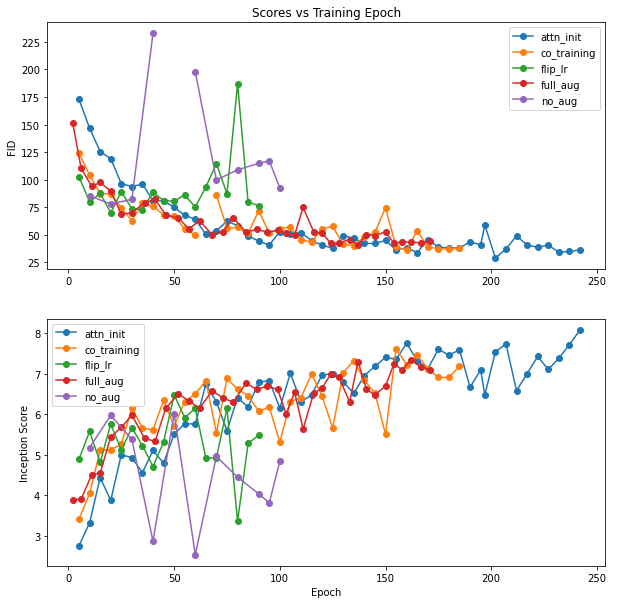

In [36]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

for idx, exp in enumerate(results.keys()):
  e = results[exp]['epochs']
  fid = results[exp]['fids']
  inception_score = results[exp]['iss']
  score = [s[0] for s in inception_score]

  axs[0].plot(e,fid,'-o',label=exp)
  axs[1].plot(e,score,'-o', label=exp)

axs[0].set_ylabel('FID')
axs[1].set_ylabel('Inception Score')

plt.title('Scores vs Training Epoch')
plt.xlabel("Epoch")

axs[0].legend()
axs[1].legend()
plt.show()

In [37]:
from tabulate import tabulate
table = []
for exp in results.keys():
  inception_score = [s[0] for s in results[exp]['iss']]
  table.append([exp,max(results[exp]['epochs']),results[exp]['epochs'][np.nanargmin(results[exp]['fids'])], min(results[exp]['fids']), results[exp]['epochs'][np.nanargmax(inception_score)], max(inception_score)])

print(tabulate(table, headers=["Experiment","Training Epochs","Min FID Epoch", "Min FID", "Max IS Epoch", "Max IS"]))

Experiment      Training Epochs    Min FID Epoch    Min FID    Max IS Epoch    Max IS
------------  -----------------  ---------------  ---------  --------------  --------
attn_init                   242              202    28.7528             242   8.08049
co_training                 185              160    36.1584             155   7.6132
flip_lr                      90               20    69.9796              50   6.48188
full_aug                    171              137    40.784              162   7.3485
no_aug                      100               20    77.8442              50   6.01709
